In [1]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import datetime 
import matplotlib.dates as mdates

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
from matplotlib import rcParams

plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 16
rcParams['axes.linewidth'] = 2

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
# df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y %H:%M')
load = df['T (degC)']
time = df['datetime']

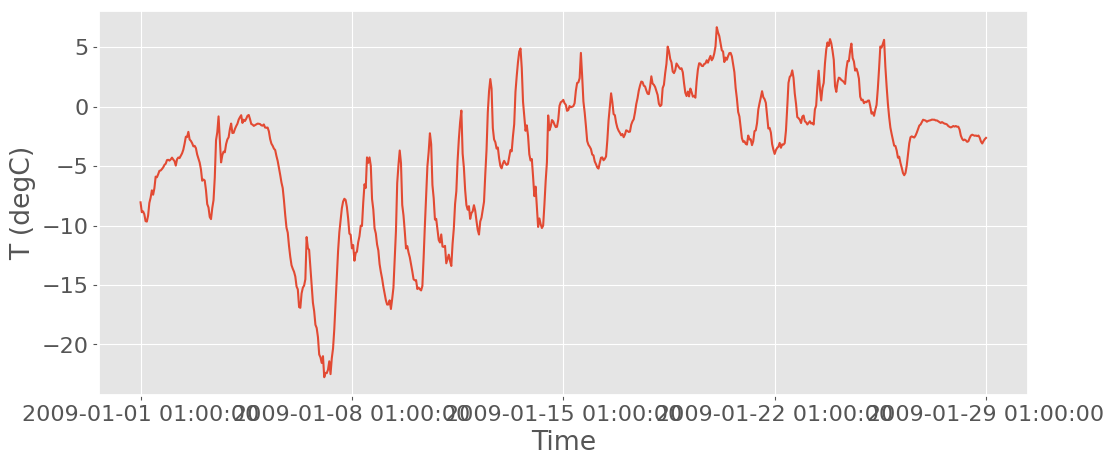

In [4]:
plt.plot(time[:673], load[:673])
plt.xticks(np.arange(0, 673, step = 168))
plt.xlabel('Time')
plt.ylabel('T (degC)')
# plt.savefig('UsageWeek.png')
plt.show()

In [ ]:
# #replace 0 value with the minimum value except 0
# second_min = min(load[load != 0])
# load[load == 0] = second_min
# display(load[load == 0])

In [5]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

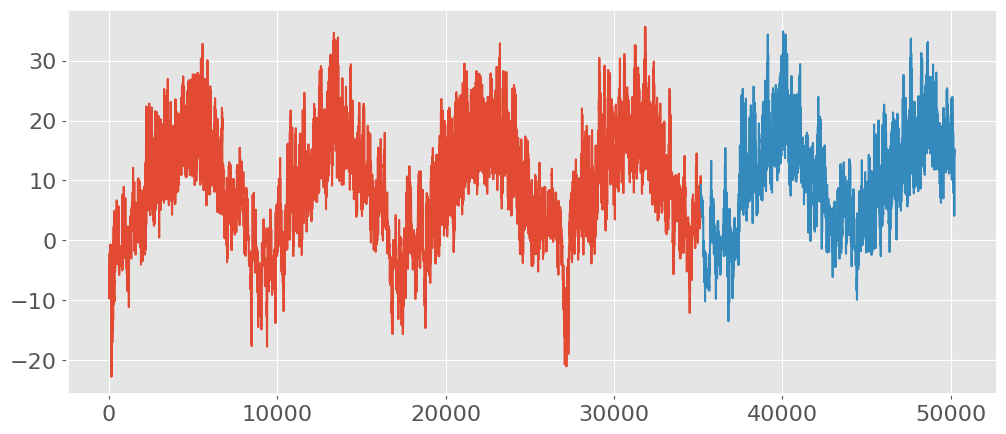

In [6]:
train = load[:int(len(load)*0.7)]
test = load[int(len(load)*0.7):]
plt.plot(train)
plt.plot(test)
plt.show()

<Figure size 1200x500 with 0 Axes>

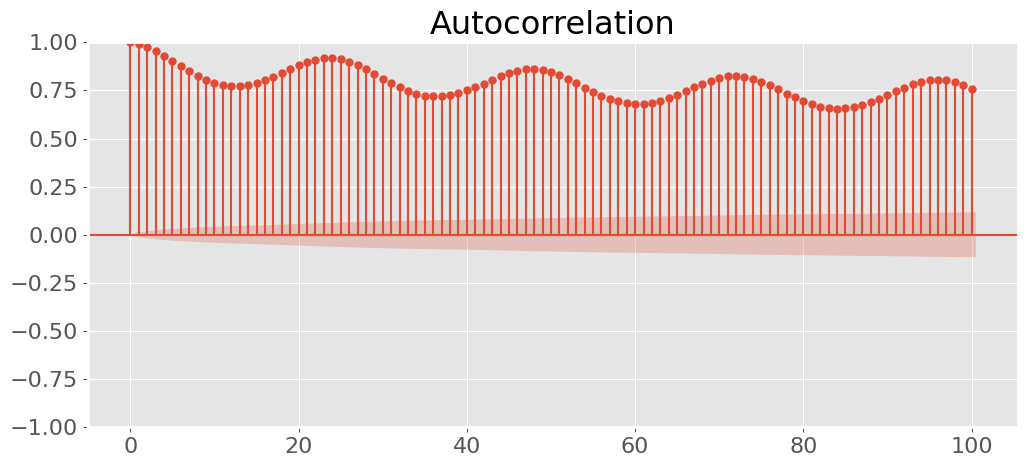

<Figure size 1200x500 with 0 Axes>

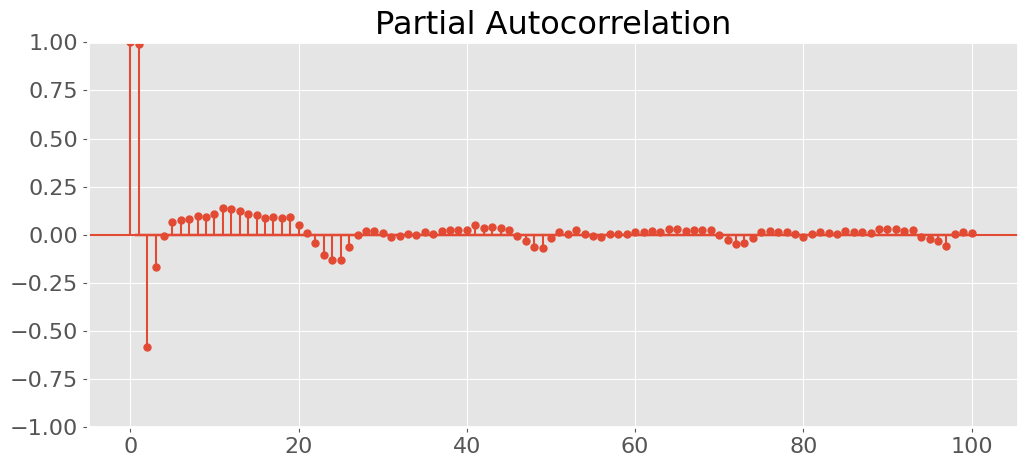

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
acf_values = acf(train)
plot_acf(train, lags=100)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=100)
plt.show()

In [8]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1,4):
    df_train["lag{}".format(i)] = df_train["T (degC)"].shift(i)
    df_test["lag{}".format(i)] = df_test["T (degC)"].shift(i)

# df_train = pd.merge(df_train, other_vars_train, left_index=True, right_index=True, how = 'outer')
# df_test = pd.merge(df_test, other_vars_test, left_index=True, right_index=True, how = 'outer')

df_train = df_train.fillna(0)
df_train = df_train.drop(columns = ["T (degC)"])
df_test = df_test.fillna(0)
df_test = df_test.drop(columns = ["T (degC)"])

display(df_train, df_test)

,lag1,lag2,lag3
0,0.00,0.00,0.00
1,-8.05,0.00,0.00
2,-8.88,-8.05,0.00
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
35151,9.93,10.13,10.74
35152,9.87,9.93,10.13
35153,9.67,9.87,9.93
35154,9.60,9.67,9.87


,lag1,lag2,lag3
35156,0.00,0.00,0.00
35157,9.23,0.00,0.00
35158,8.99,9.23,0.00
35159,9.08,8.99,9.23
35160,8.86,9.08,8.99
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# ARIMA

In [9]:
from statsmodels.tsa.arima.model import ARIMA
 
# Build Model
arima = ARIMA(train, order=(1, 1, 1)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:               T (degC)   No. Observations:                35156
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -43586.991
Date:                Thu, 03 Oct 2024   AIC                          87179.981
Time:                        18:56:18   BIC                          87205.384
Sample:                             0   HQIC                         87188.071
                              - 35156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7158      0.006    128.830      0.000       0.705       0.727
ma.L1         -0.2061      0.006    -31.746      0.000      -0.219      -0.193
sigma2         0.6989      0.002    284.290      0.0

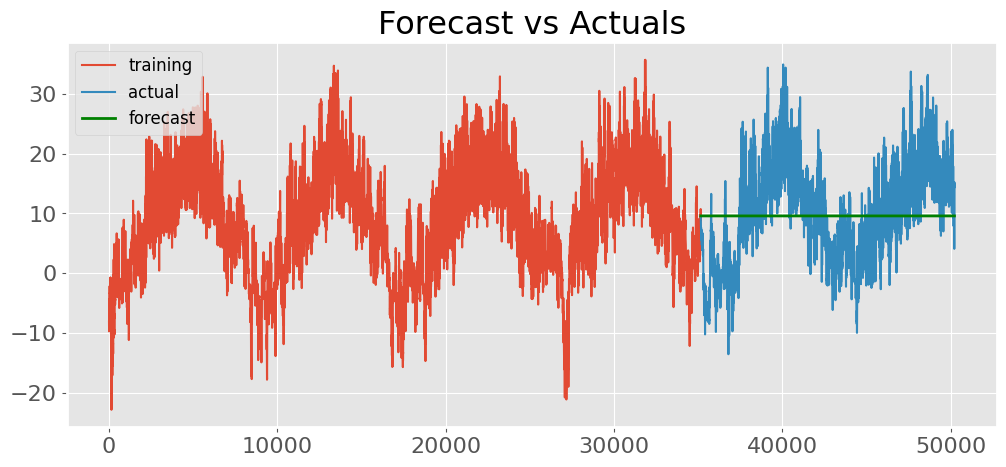

In [10]:
# plotting
arima_fc = arima.forecast(len(test)) 

# Make as pandas series
fc_series = pd.Series(arima_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(fc_series, label='forecast', linewidth = 2, c = 'g')
# plt.plot(arima.predict(), label = 'fit')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
# plt.savefig('ARIMA.png')
plt.show()

In [11]:
RMSE_ARIMA = mean_squared_error(test, arima_fc)
MAE_ARIMA  =mean_absolute_error(test, arima_fc)
MAPE_ARIMA = mean_absolute_percentage_error(test, arima_fc)
print('RMSE = {}'.format(RMSE_ARIMA), '\nMAE = {}'.format(MAE_ARIMA), '\nMAPE = {}'.format(MAPE_ARIMA))

RMSE = 68.24993441537978 
MAE = 6.81926708453413 
MAPE = 20066536008421.85


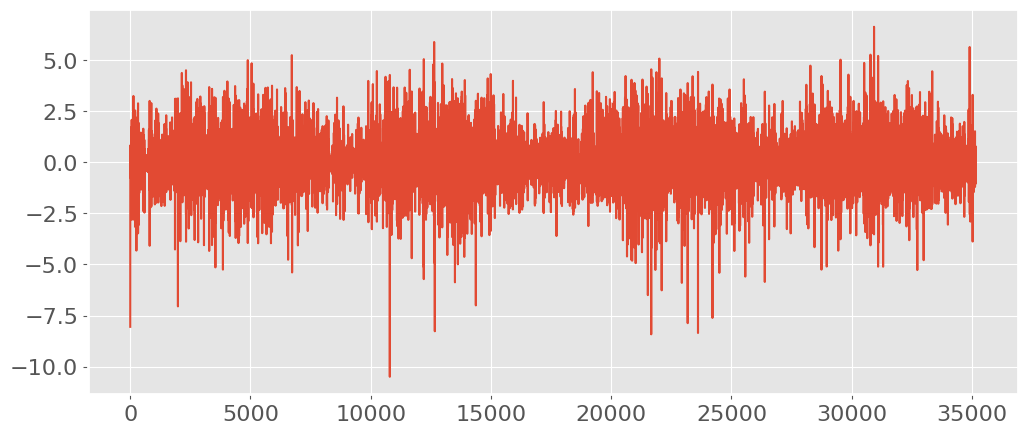

In [12]:
plt.plot(arima.resid)
# plt.savefig('arimaresid')
plt.show()

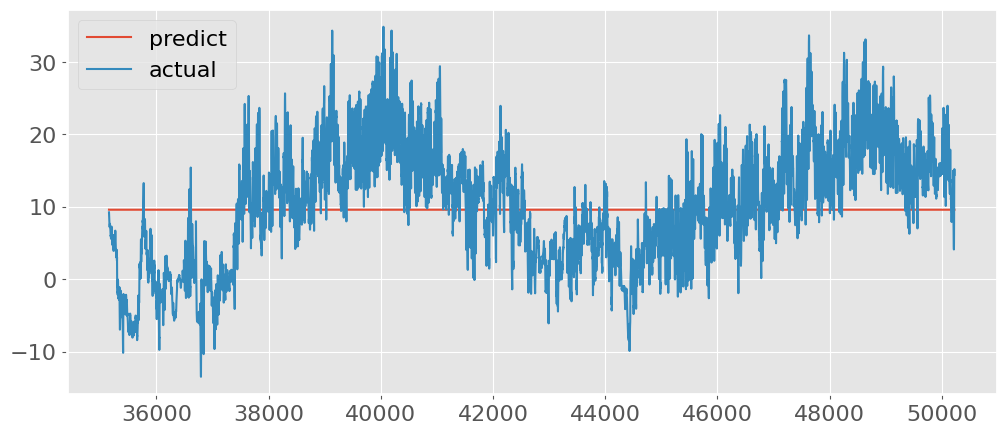

In [13]:
plt.plot(arima_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
# plt.savefig('ARIMApredict')
plt.show()

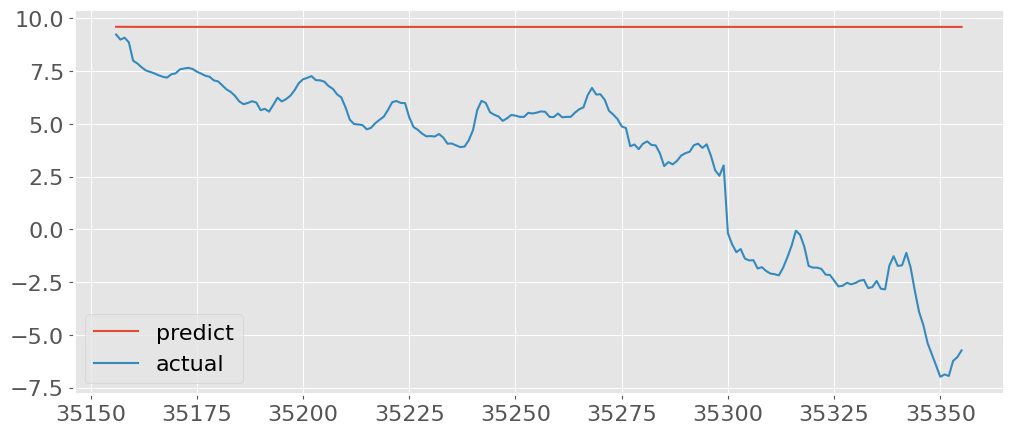

In [14]:
plt.plot(arima_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
# plt.savefig('ARIMApredict_200')
plt.show()

In [15]:
arima_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
arima_SVR.fit(df_train.values, arima.resid)
arima_SVR_fc = arima_SVR.predict(np.array(df_test))

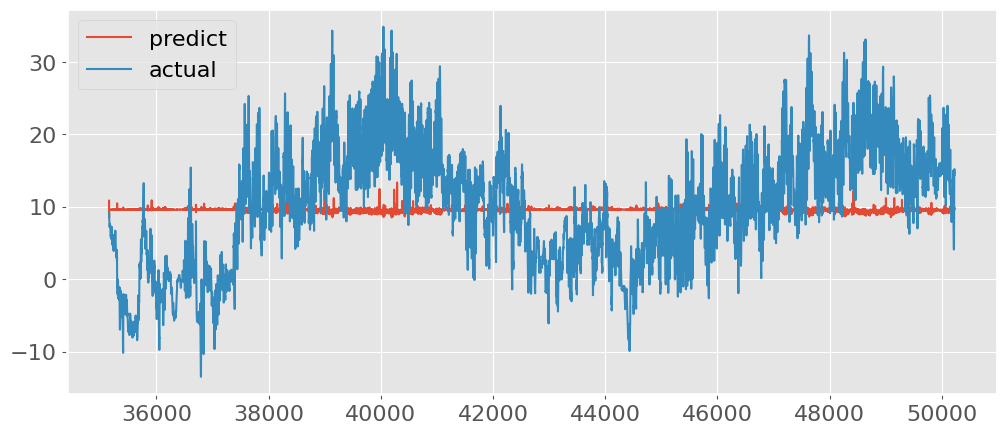

In [16]:
# print(arimia_SVR)
plt.plot(arima_SVR_fc+arima_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
# plt.savefig('ARIMASVR')
plt.show()

In [17]:
RMSE_arima_svm = mean_squared_error(test, arima_SVR_fc+arima_fc)
MAE_arima_svm  =mean_absolute_error(test, arima_SVR_fc+arima_fc)
MAPE_arima_svm = mean_absolute_percentage_error(test, arima_SVR_fc+arima_fc)
print('RMSE = {}'.format(RMSE_arima_svm), '\nMAE = {}'.format(MAE_arima_svm), '\nMAPE = {}'.format(MAPE_arima_svm))

RMSE = 69.74687776162672 
MAE = 6.88042501195158 
MAPE = 20148494711708.957


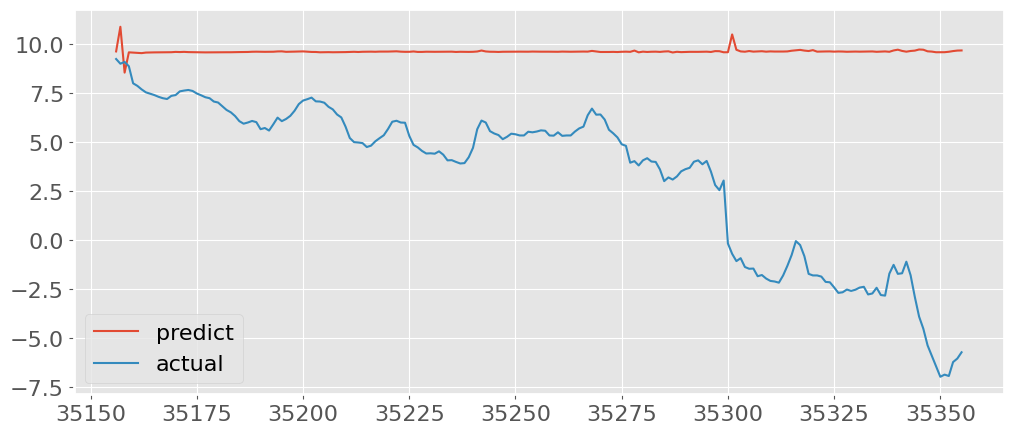

In [18]:
#test area
plt.plot(arima_SVR_fc[:200]+arima_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
# plt.savefig('ARIMASVR_200')
plt.show()

# Holt-Winter - SVM

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
holt_winter = HWES(train, seasonal_periods=12, trend = 'add', seasonal='add').fit()
print(holt_winter.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 T (degC)   No. Observations:                35156
Model:             ExponentialSmoothing   SSE                          27022.217
Optimized:                         True   AIC                          -9218.807
Trend:                         Additive   BIC                          -9083.326
Seasonal:                      Additive   AICC                         -9218.787
Seasonal Periods:                    12   Date:                 Thu, 03 Oct 2024
Box-Cox:                          False   Time:                         19:01:13
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9999993                alpha                 True
smoothing_trend          

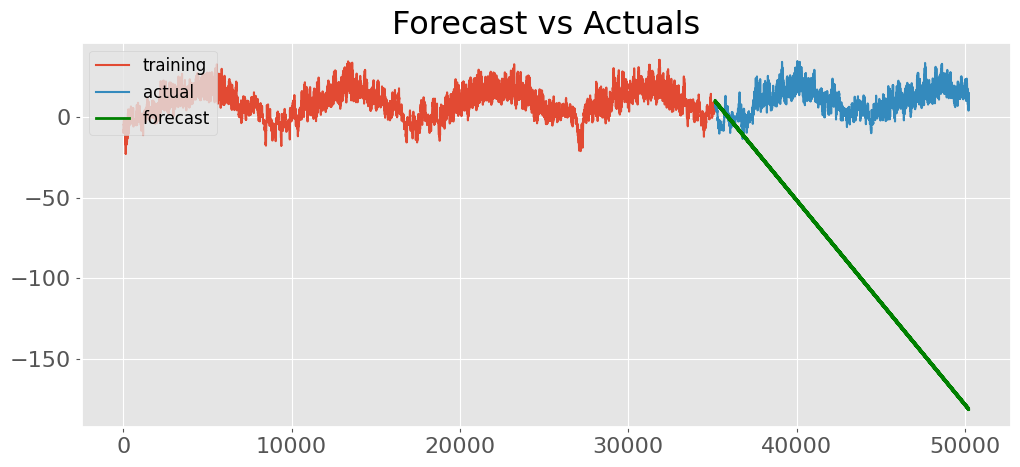

35156    9.813147
dtype: float64


In [20]:
hw_fc = holt_winter.forecast(len(test)) 

# Make as pandas series
hw_series = pd.Series(hw_fc, index = [x for x in range(len(train),len(train)+len(test))])
test_series = pd.Series(test, index = [x for x in range(len(train),len(train)+len(test))])
# Plot
plt.plot(train, label='training')
plt.plot(test_series, label='actual')
plt.plot(hw_series, label='forecast', linewidth = 2, c = 'g')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
# plt.savefig('HW')
plt.show()
print(holt_winter.predict(len(train)))

In [21]:
RMSE_HW = mean_squared_error(test, hw_fc)
MAE_HW  =mean_absolute_error(test, hw_fc)
MAPE_HW = mean_absolute_percentage_error(test, hw_fc)
print('RMSE = {}'.format(RMSE_HW), '\nMAE = {}'.format(MAE_HW), '\nMAPE = {}'.format(MAPE_HW))

RMSE = 12622.985926553945 
MAE = 96.51744931463604 
MAPE = 88409716058082.34


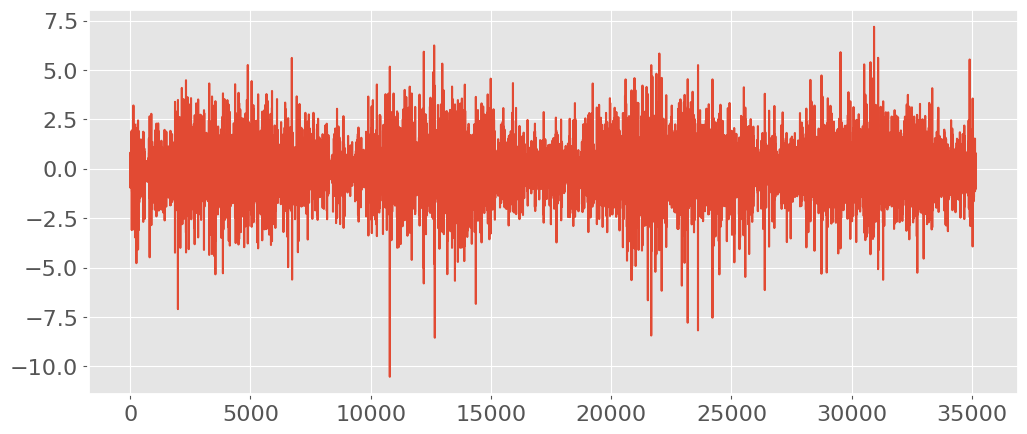

In [22]:
plt.plot(holt_winter.resid)
# plt.savefig('hwresid')
plt.show()

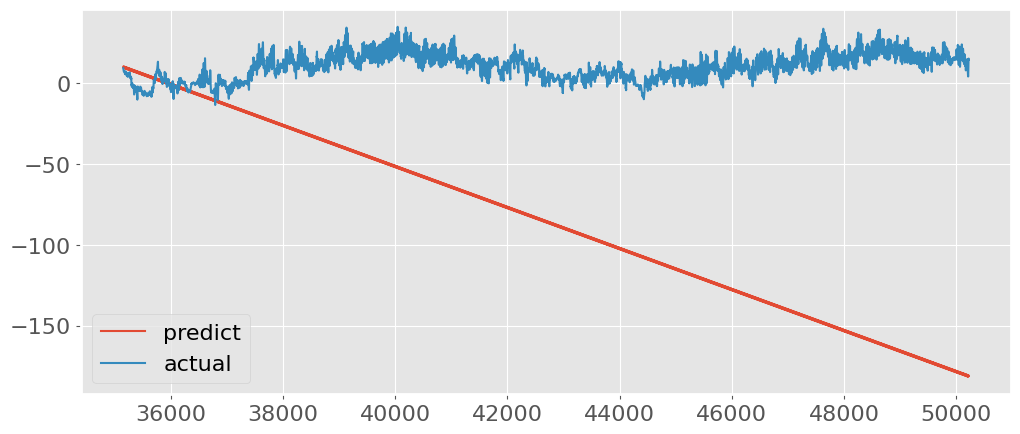

In [23]:
plt.plot(hw_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
# plt.savefig('HWpredict')
plt.show()

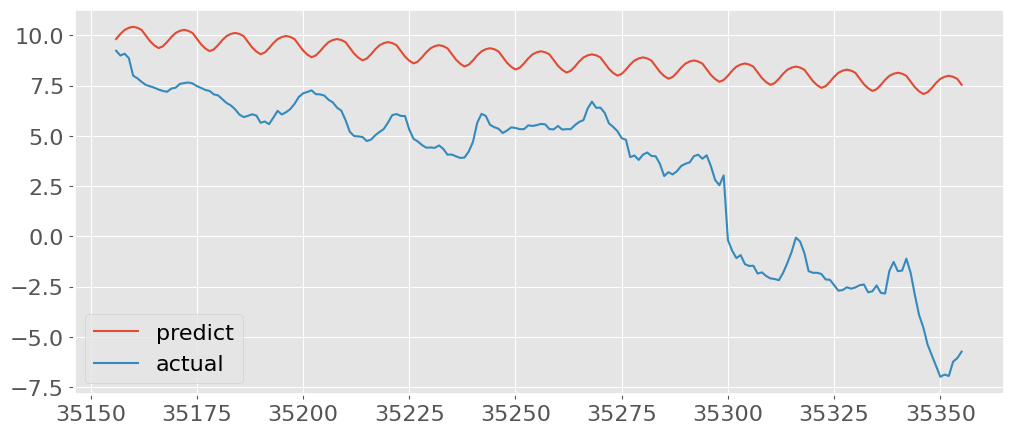

In [24]:
plt.plot(hw_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
# plt.savefig('HWpredict_200')
plt.show()

In [25]:
hw_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
hw_SVR.fit(df_train.values, holt_winter.resid)

hw_SVR_fc = hw_SVR.predict(np.array(df_test))

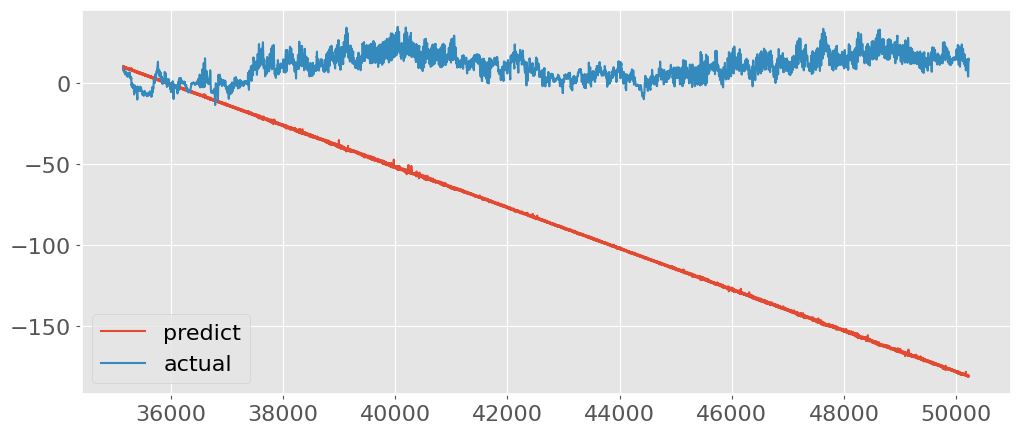

In [26]:
plt.plot(hw_SVR_fc+hw_fc, label = 'predict')
plt.plot(test, label = 'actual')
plt.legend()
# plt.savefig('HWSVR')
plt.show()

In [27]:
RMSE_hw_SVR = mean_squared_error(test, hw_SVR_fc+hw_fc)
MAE_hw_SVR  =mean_absolute_error(test, hw_SVR_fc+hw_fc)
MAPE_hw_SVR = mean_absolute_percentage_error(test, hw_SVR_fc+hw_fc)
print('RMSE = {}'.format(RMSE_hw_SVR), '\nMAE = {}'.format(MAE_hw_SVR), '\nMAPE = {}'.format(MAPE_hw_SVR))

RMSE = 12633.70473420553 
MAE = 96.55251197095122 
MAPE = 88163309872502.75


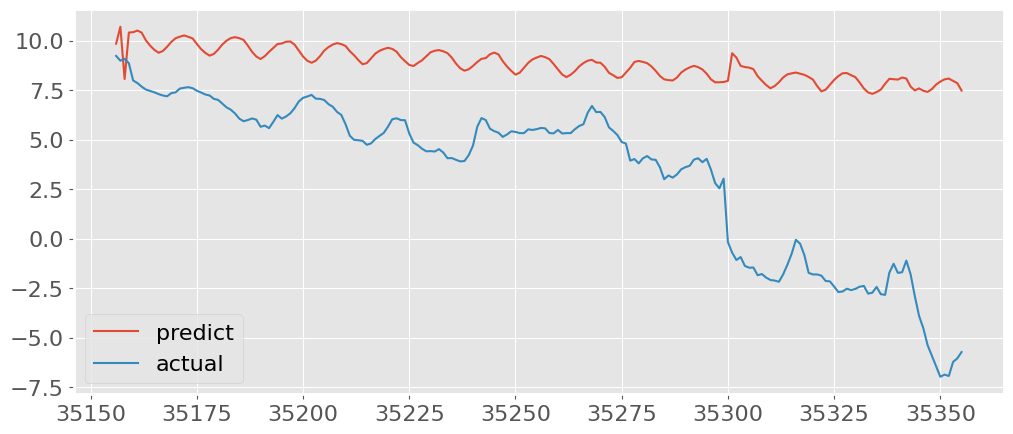

In [28]:
plt.plot(hw_SVR_fc[:200]+hw_fc[:200], label = 'predict')
plt.plot(test[:200], label = 'actual')
plt.legend()
# plt.savefig('HWSVR_200')
plt.show()

# SVM

In [29]:
SVR_m = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(df_train.values, train)

SVR_fc = SVR_m.predict(np.array(df_test))

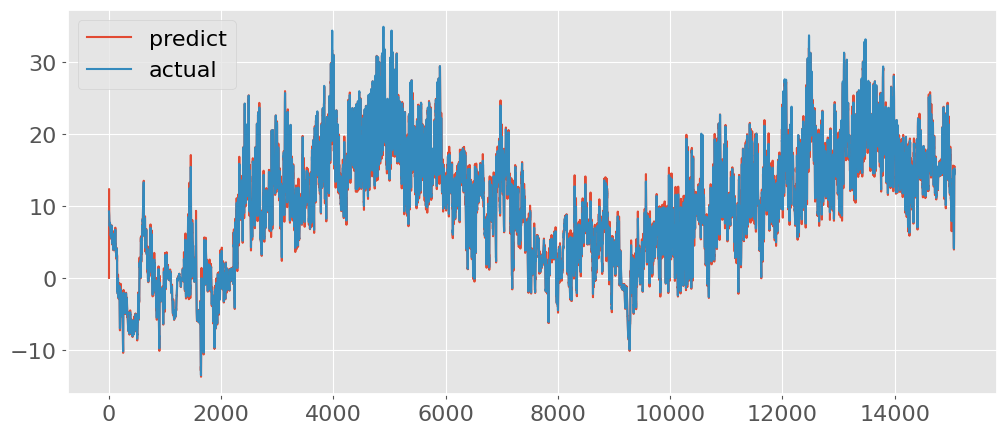

In [30]:
plt.plot(SVR_fc, label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
# plt.savefig('SVR')
plt.show()

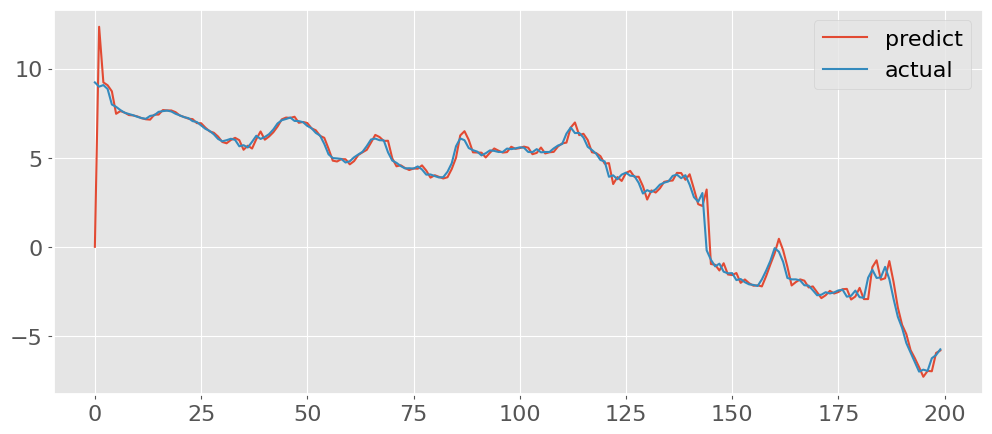

In [31]:
plt.plot(SVR_fc[:200], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
# plt.savefig('SVR_200')
plt.show()

In [32]:
RMSE_SVR = mean_squared_error(test, SVR_fc)
MAE_SVR  =mean_absolute_error(test, SVR_fc)
MAPE_SVR = mean_absolute_percentage_error(test, SVR_fc)
print('RMSE = {}'.format(RMSE_SVR), '\nMAE = {}'.format(MAE_SVR), '\nMAPE = {}'.format(MAPE_SVR))

RMSE = 0.6520841217098119 
MAE = 0.5310279724611261 
MAPE = 682861714325.9479


# Moving Average 3

In [33]:
MA_3_train = pd.DataFrame(train).rolling(window=3).mean().fillna(0)
MA_3_test = pd.DataFrame(test).rolling(window=3).mean().fillna(0)
# display(MA_3_train, MA_3_test)

In [34]:
SVR_MA_3 = SVR(kernel = 'rbf', C= 0.5, gamma= 0.01).fit(MA_3_train.values, train)
SVR_MA_3_fc = SVR_MA_3.predict(np.array(MA_3_test))

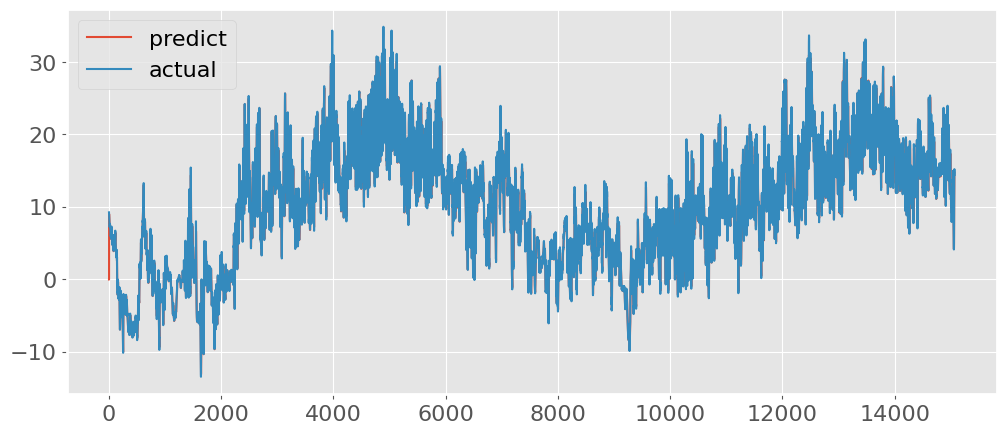

In [35]:
plt.plot(SVR_MA_3_fc, label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
# plt.savefig('SVR_MA3')
plt.show()

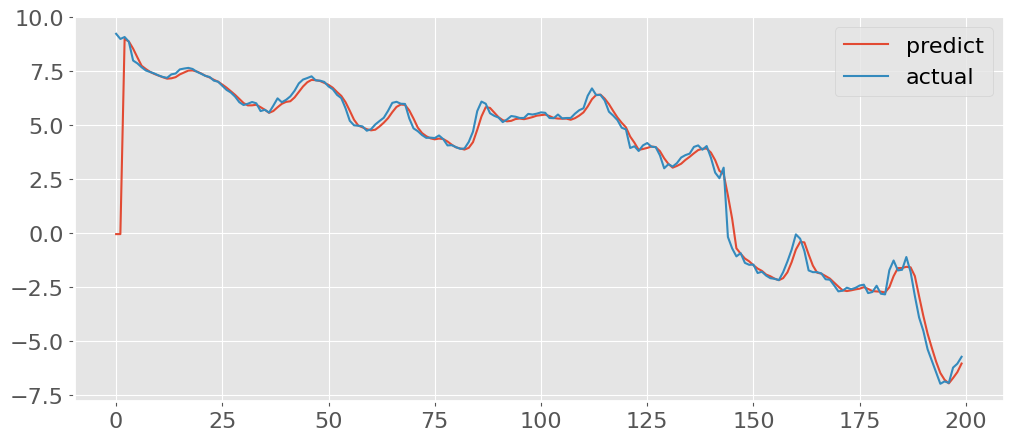

In [36]:
plt.plot(SVR_MA_3_fc[0:200], label = 'predict')
plt.plot(test.values[0:200], label = 'actual')
plt.legend()
# plt.savefig('SVR_MA3_200')
plt.show()

In [37]:
RMSE_SVR_MA3 = mean_squared_error(test, SVR_MA_3_fc)
MAE_SVR_MA3  =mean_absolute_error(test, SVR_MA_3_fc)
MAPE_SVR_MA3 = mean_absolute_percentage_error(test, SVR_MA_3_fc)
print('RMSE = {}'.format(RMSE_SVR_MA3), '\nMAE = {}'.format(MAE_SVR_MA3), '\nMAPE = {}'.format(MAPE_SVR_MA3))

RMSE = 0.8360865970252502 
MAE = 0.6397927183481023 
MAPE = 792057593162.3893


# Empirical M Decomposition - SVM¶

In [38]:
!pip install emd

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


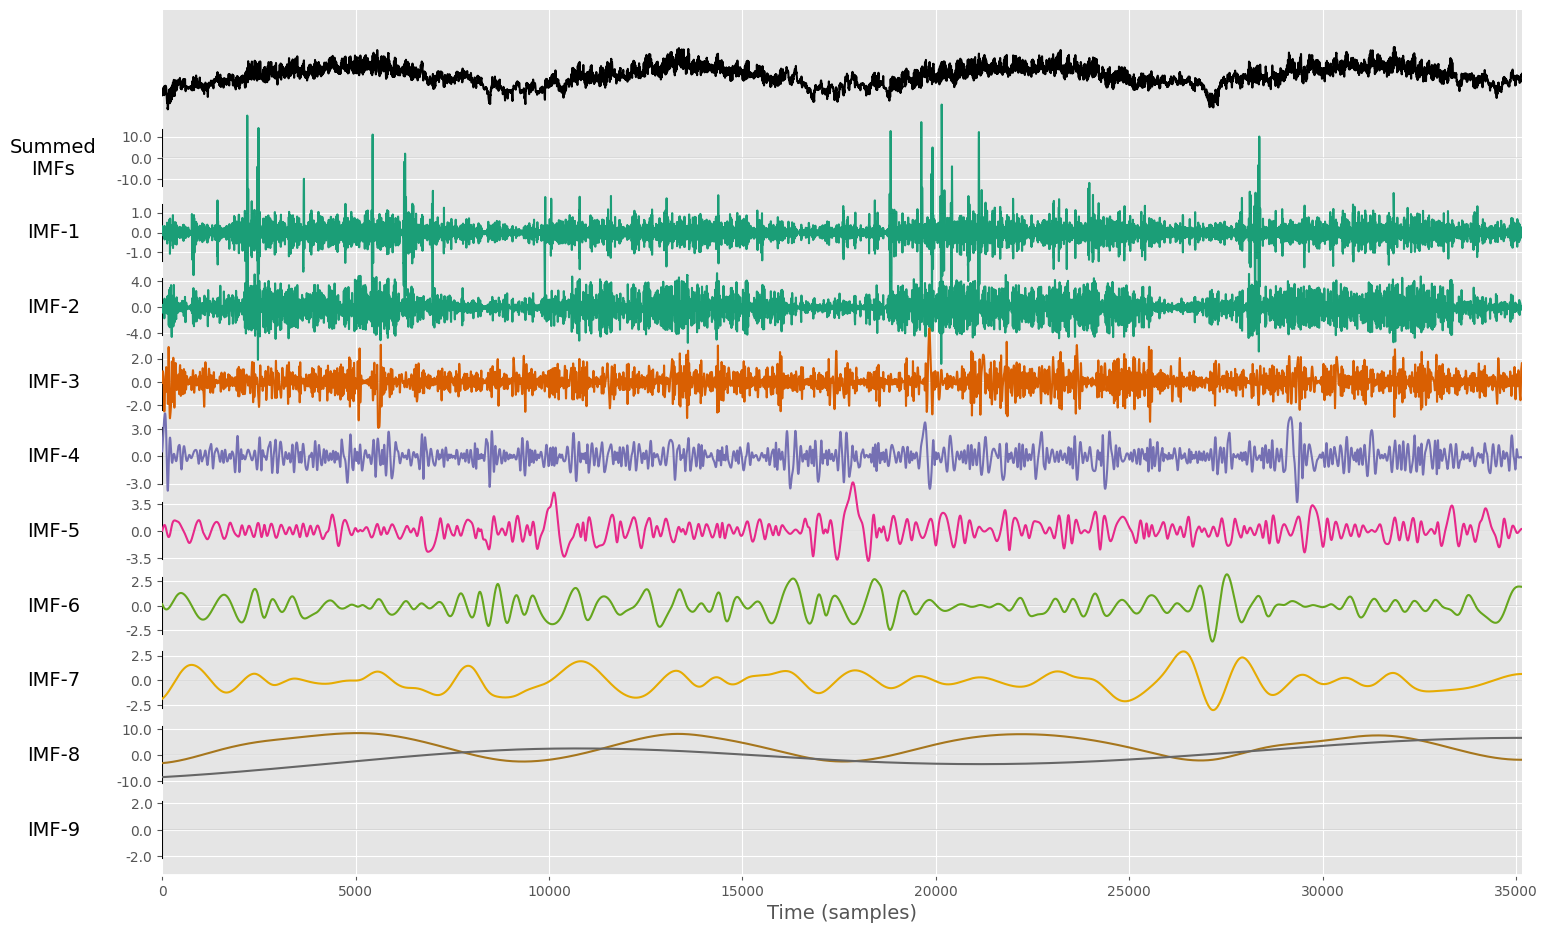

In [39]:
import emd

imf = emd.sift.sift(np.array(train), imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf, cmap=True, scale_y=True)
# plt.savefig('emd')
plt.show()

In [40]:
#put the imf into dataframe
imf_df = pd.DataFrame(data = imf)
imf_df.columns = ['imf_{}'.format(i+1) for i in range(0, imf.shape[1])]
display(imf_df)

,imf_1,imf_2,imf_3,imf_4,imf_5,imf_6,imf_7,imf_8,imf_9
0,0.624629,0.750155,0.072876,1.124321,-0.065547,0.363817,-3.580026,-12.016997,4.676773
1,-0.245501,0.825166,-0.068872,1.207308,-0.031005,0.344753,-3.574448,-12.014507,4.677106
2,0.070754,0.548892,-0.158437,1.302702,0.003648,0.325833,-3.568823,-12.012008,4.677440
3,0.212963,0.069112,-0.191950,1.409304,0.038389,0.307059,-3.563152,-12.009499,4.677773
4,-0.055081,-0.410446,-0.165875,1.526083,0.073194,0.288431,-3.557434,-12.006979,4.678107
...,...,...,...,...,...,...,...,...,...
35151,0.104264,-0.069505,3.122145,-0.270286,0.417976,3.919045,1.400292,-9.397460,10.643528
35152,0.015561,-0.105538,3.053294,-0.275835,0.417974,3.917825,1.400364,-9.397171,10.643526
35153,-0.046740,-0.038038,2.984747,-0.281354,0.417696,3.916610,1.400429,-9.396874,10.643524
35154,-0.028095,0.007579,2.927362,-0.286831,0.417144,3.915400,1.400489,-9.396570,10.643522


In [41]:
imf1_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_SVR.fit(df_train.values, imf_df['imf_1'])
imf1_SVR_fc = imf1_SVR.predict(np.array(df_test))

imf2_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_SVR.fit(df_train.values, imf_df['imf_2'])
imf2_SVR_fc = imf2_SVR.predict(np.array(df_test))

imf3_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_SVR.fit(df_train.values, imf_df['imf_3'])
imf3_SVR_fc = imf3_SVR.predict(np.array(df_test))

imf4_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_SVR.fit(df_train.values, imf_df['imf_4'])
imf4_SVR_fc = imf4_SVR.predict(np.array(df_test))

imf5_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_SVR.fit(df_train.values, imf_df['imf_5'])
imf5_SVR_fc = imf5_SVR.predict(np.array(df_test))

imf6_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_SVR.fit(df_train.values, imf_df['imf_6'])
imf6_SVR_fc = imf6_SVR.predict(np.array(df_test))

imf7_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_SVR.fit(df_train.values, imf_df['imf_7'])
imf7_SVR_fc = imf7_SVR.predict(np.array(df_test))

imf8_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_SVR.fit(df_train.values, imf_df['imf_8'])
imf8_SVR_fc = imf8_SVR.predict(np.array(df_test))

imf9_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_SVR.fit(df_train.values, imf_df['imf_9'])
imf9_SVR_fc = imf9_SVR.predict(np.array(df_test))

# imf10_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
# imf10_SVR.fit(df_train.values, imf_df['imf_10'])
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_test))

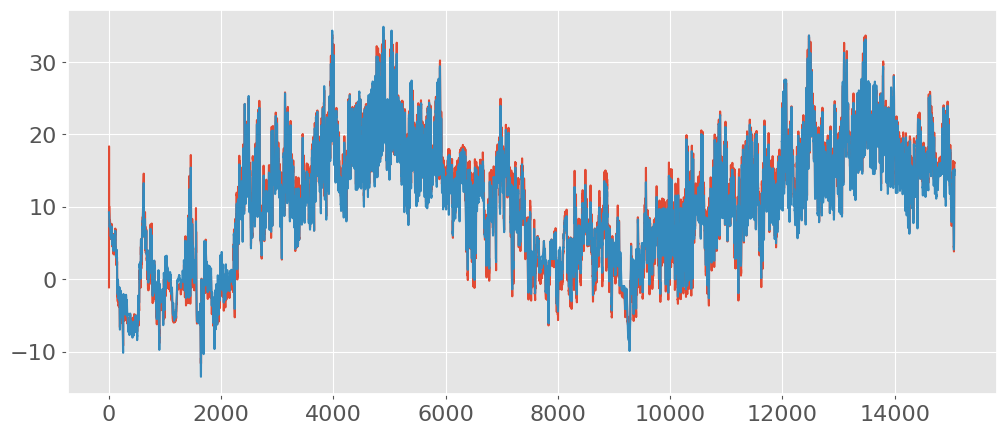

In [42]:
imf_list = ['imf{}_SVR_fc'.format(i) for i in range(1,11)]

imf_fc = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc], axis = 0)

plt.plot(imf_fc)
plt.plot(test.values)

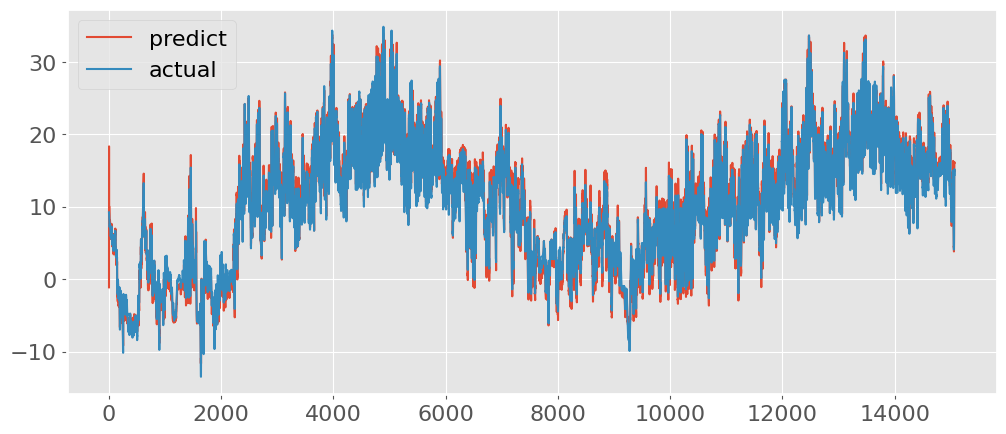

RMSE = 1.3723257073462738 
MAE = 0.9420968476146955 
MAPE = 2130653149264.4375


In [43]:
plt.plot(imf_fc,label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
# plt.savefig('EMDSVR')
plt.show()

RMSE_EMD_SVR = mean_squared_error(test, imf_fc)
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc)
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

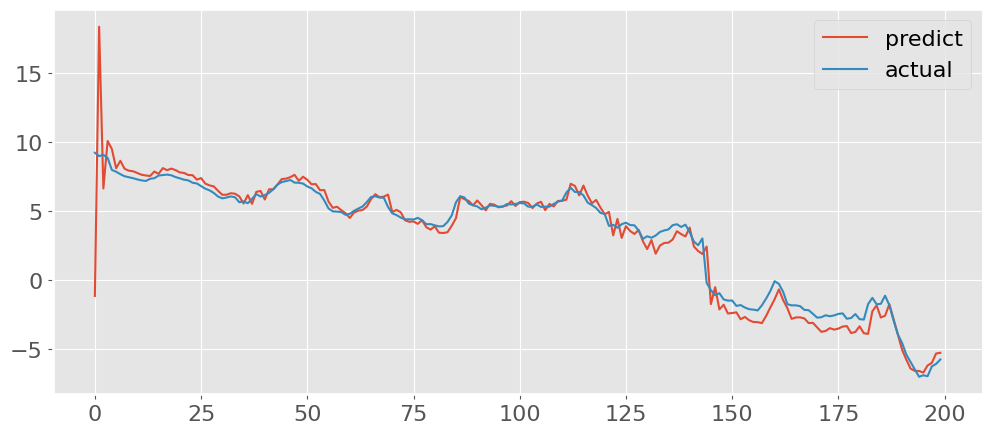

In [44]:
plt.plot(imf_fc[:200], label = 'predict')
plt.plot(test[:200].values, label = 'actual')
plt.legend()
# plt.savefig('EMDSVR_200')
plt.show()

In [45]:
imf1_SVR_fc = imf1_SVR.predict(np.array(df_train))
imf2_SVR_fc = imf2_SVR.predict(np.array(df_train))
imf3_SVR_fc = imf3_SVR.predict(np.array(df_train))
imf4_SVR_fc = imf4_SVR.predict(np.array(df_train))
imf5_SVR_fc = imf5_SVR.predict(np.array(df_train))
imf6_SVR_fc = imf6_SVR.predict(np.array(df_train))
imf7_SVR_fc = imf7_SVR.predict(np.array(df_train))
imf8_SVR_fc = imf8_SVR.predict(np.array(df_train))
imf9_SVR_fc = imf9_SVR.predict(np.array(df_train))
# imf10_SVR_fc = imf10_SVR.predict(np.array(df_train))

imf_fc_train = np.sum([imf1_SVR_fc, imf2_SVR_fc, imf3_SVR_fc,
                imf4_SVR_fc, imf5_SVR_fc,imf6_SVR_fc,
                imf7_SVR_fc,imf8_SVR_fc,imf9_SVR_fc], axis = 0)

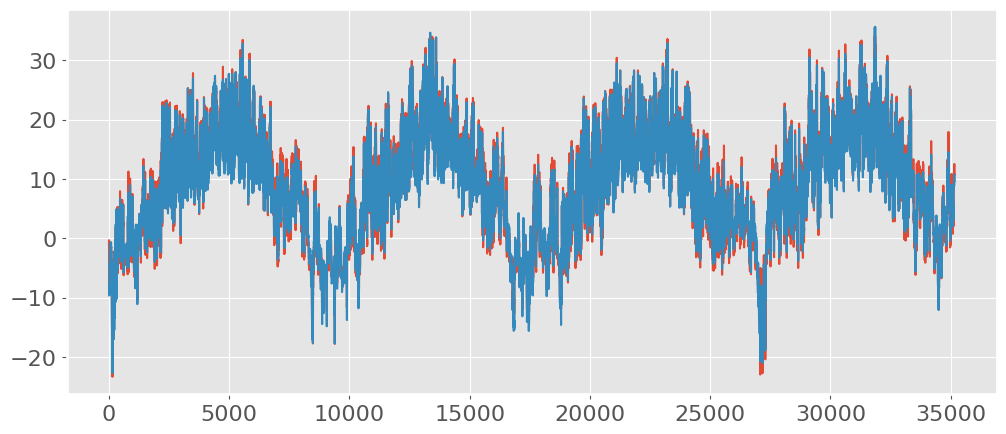

In [46]:
plt.plot(imf_fc_train)
plt.plot(train.values)

In [47]:
RMSE_EMD_SVR = mean_squared_error(train, imf_fc_train, squared = False)
MAE_EMD_SVR  =mean_absolute_error(train, imf_fc_train)
MAPE_EMD_SVR = mean_absolute_percentage_error(train, imf_fc_train)
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 1.2090701126903611 
MAE = 0.9735505280264448 
MAPE = 2607889809266.408


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [48]:
import numpy as np
from scipy.optimize import minimize

def dummy(c):
    global  train
    global imf_fc_train
    return mean_squared_error(train, imf_fc_train + c, squared = False)

res = minimize(dummy, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 1.189819
         Iterations: 33
         Function evaluations: 67
[-0.21489725]


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

In [49]:
RMSE_EMD_SVR = mean_squared_error(test, imf_fc + res.x[0])
MAE_EMD_SVR  =mean_absolute_error(test, imf_fc + res.x[0])
MAPE_EMD_SVR = mean_absolute_percentage_error(test, imf_fc + res.x[0])
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

RMSE = 1.3210977257570975 
MAE = 0.9070006697969317 
MAPE = 2580260140271.825


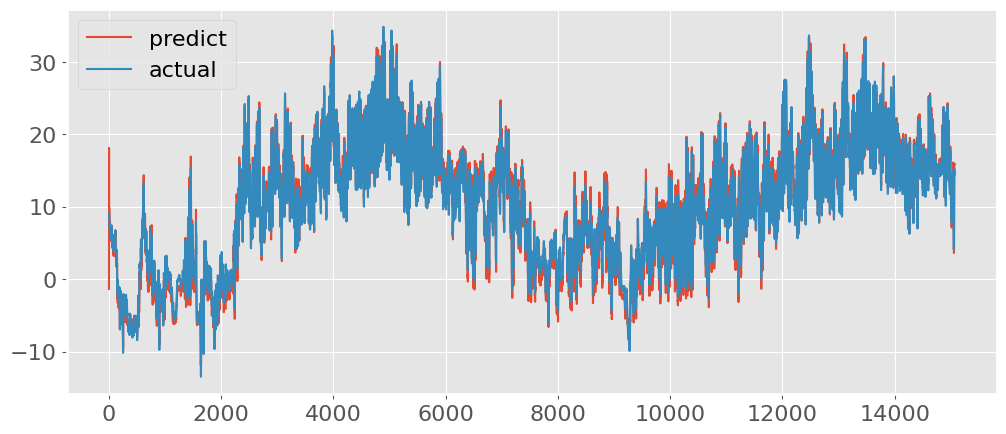

In [50]:
plt.plot(imf_fc + res.x[0], label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
# plt.savefig('ImprovedEMDSVR')
plt.show()

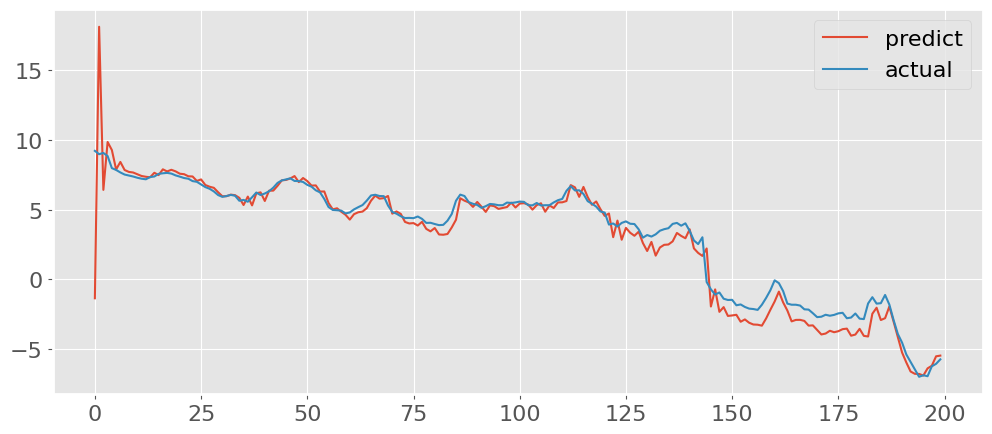

RMSE = 1.3210977257570975 
MAE = 0.9070006697969317 
MAPE = 2580260140271.825


In [51]:
plt.plot(imf_fc[:200] + res.x[0], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
# plt.savefig('ImprovedEMDSVR_200')
plt.show()
print('RMSE = {}'.format(RMSE_EMD_SVR), '\nMAE = {}'.format(MAE_EMD_SVR), '\nMAPE = {}'.format(MAPE_EMD_SVR))

# EEMD

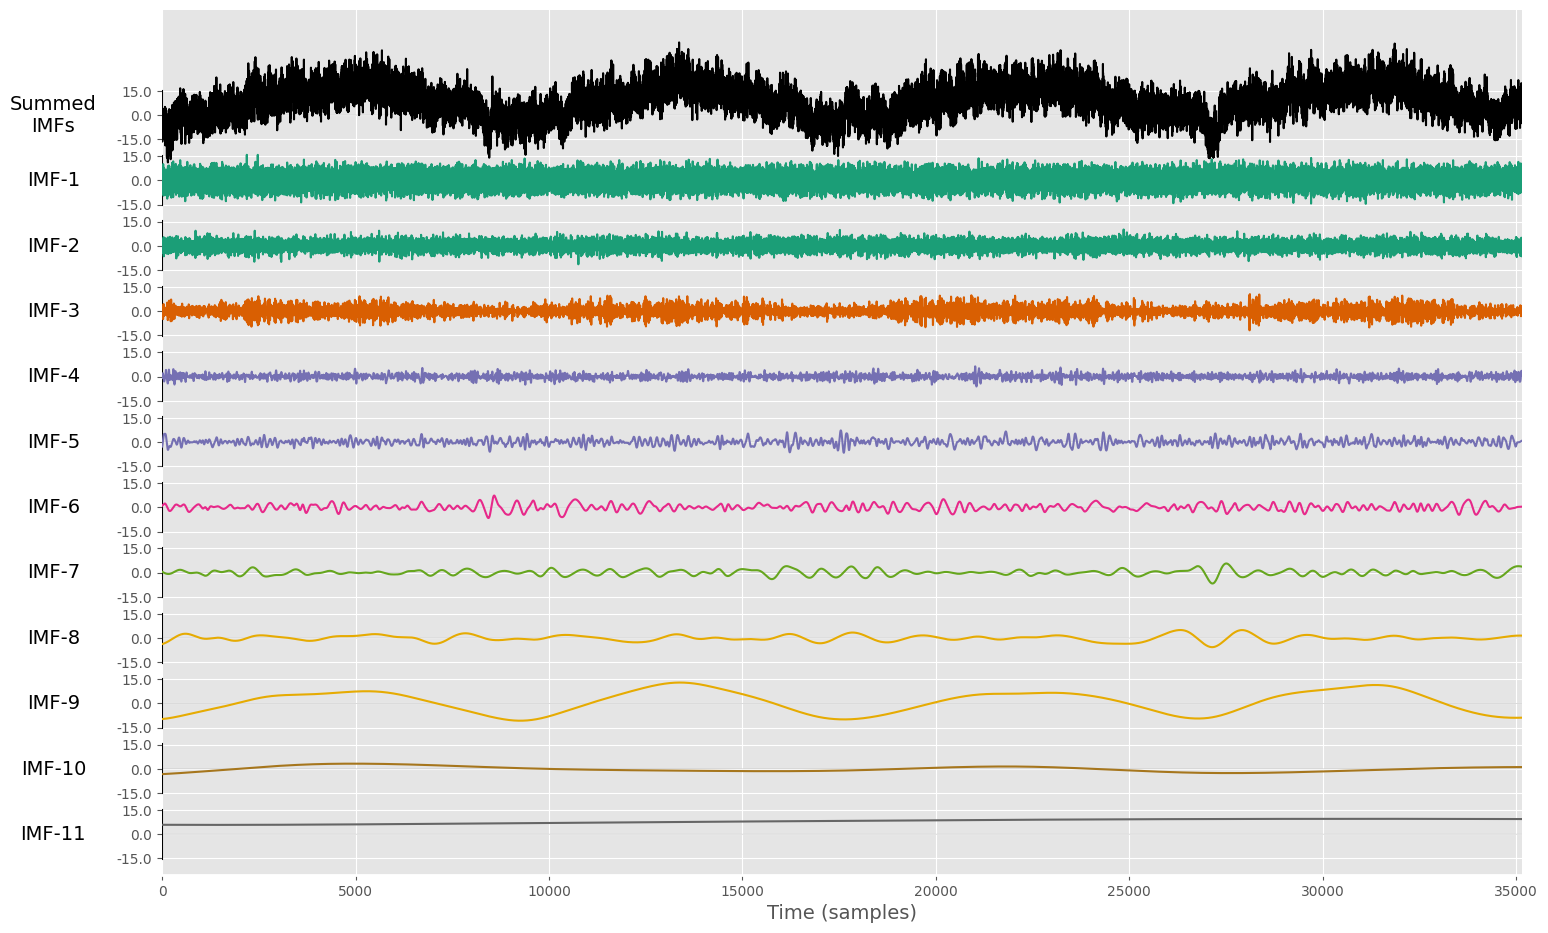

In [52]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)
# plt.savefig('eemd')

In [53]:
imf_eemd_df = pd.DataFrame(data = imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,0.616488,3.725274,0.730350,-0.713249,-2.840794,1.020744,0.615590,-3.726965,-9.685746,-3.302739,5.821425
1,-0.738294,2.666580,0.956274,-0.727942,-2.725320,1.036348,0.600089,-3.720607,-9.683325,-3.301446,5.821338
2,-1.629764,1.381559,1.032090,-0.691424,-2.596782,1.052572,0.584645,-3.714183,-9.680895,-3.300151,5.821251
3,6.518892,0.081774,0.955722,-0.607621,-2.455916,1.069399,0.569258,-3.707693,-9.678457,-3.298857,5.821164
4,-4.388395,-0.793934,0.746191,-0.479880,-2.303474,1.086810,0.553930,-3.701137,-9.676009,-3.297561,5.821077
...,...,...,...,...,...,...,...,...,...,...,...
35151,-6.904199,-0.418442,0.654685,0.690684,0.793424,0.410458,3.761641,1.512091,-8.831848,1.082358,9.377517
35152,4.532695,0.858897,0.667156,0.647559,0.796971,0.411922,3.756730,1.511364,-8.831082,1.082413,9.377447
35153,-4.274721,0.754906,0.647063,0.654923,0.799558,0.413394,3.751794,1.510626,-8.830311,1.082467,9.377376
35154,1.658535,-1.379339,0.611964,0.711170,0.801197,0.414874,3.746831,1.509877,-8.829536,1.082520,9.377306


In [54]:
imf1_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf1_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_1'])
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_test))

imf2_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf2_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_2'])
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_test))

imf3_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf3_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_3'])
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_test))

imf4_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf4_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_4'])
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_test))

imf5_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf5_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_5'])
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_test))

imf6_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf6_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_6'])
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_test))

imf7_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf7_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_7'])
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_test))

imf8_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf8_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_8'])
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_test))

imf9_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf9_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_9'])
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_test))

imf10_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf10_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_10'])
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_test))

imf11_eemd_SVR = SVR(kernel = 'rbf', C= 10, gamma= 0.01)
imf11_eemd_SVR.fit(df_train.values, imf_eemd_df['imf_eemd_11'])
imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_test))

In [55]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

imf_eemd_fc = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc, imf11_eemd_SVR_fc], axis = 0)

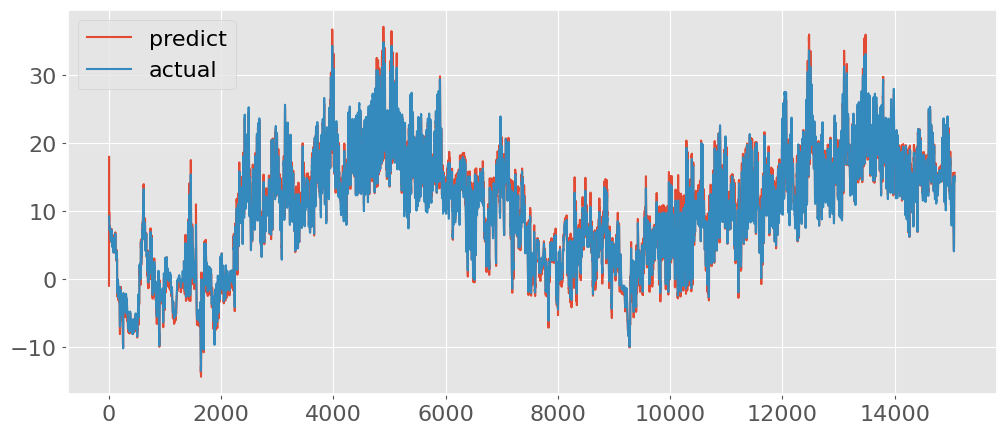

RMSE = 1.0302411951536823 
MAE = 0.7605627813715253 
MAPE = 1847071052328.2


In [56]:
plt.plot(imf_eemd_fc,label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
# plt.savefig('EEMDSVR')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

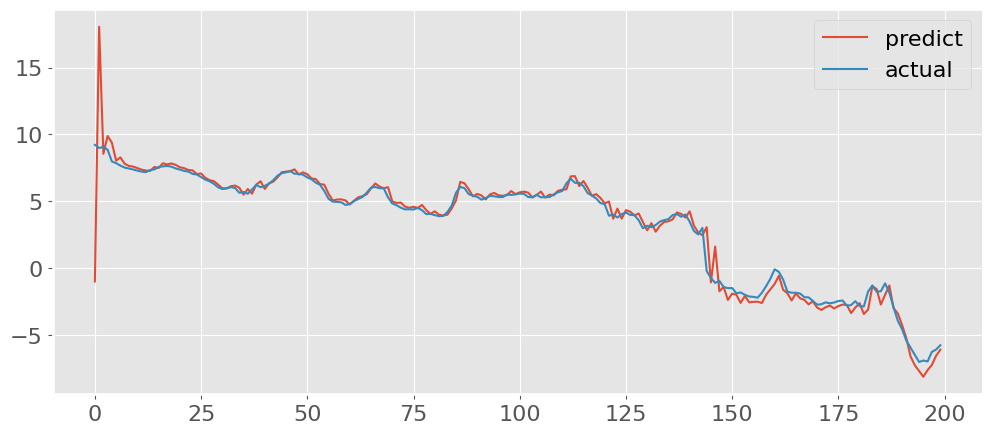

MSE = 1.0302411951536823 
MAE = 0.7605627813715253 
MAPE = 1847071052328.2


In [57]:
plt.plot(imf_eemd_fc[:200], label = 'predict')
plt.plot(test[:200].values, label = 'actual')
plt.legend()
# plt.savefig('EEMDSVR_200')
plt.show()

RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [58]:
imf1_eemd_SVR_fc = imf1_eemd_SVR.predict(np.array(df_train))
imf2_eemd_SVR_fc = imf2_eemd_SVR.predict(np.array(df_train))
imf3_eemd_SVR_fc = imf3_eemd_SVR.predict(np.array(df_train))
imf4_eemd_SVR_fc = imf4_eemd_SVR.predict(np.array(df_train))
imf5_eemd_SVR_fc = imf5_eemd_SVR.predict(np.array(df_train))
imf6_eemd_SVR_fc = imf6_eemd_SVR.predict(np.array(df_train))
imf7_eemd_SVR_fc = imf7_eemd_SVR.predict(np.array(df_train))
imf8_eemd_SVR_fc = imf8_eemd_SVR.predict(np.array(df_train))
imf9_eemd_SVR_fc = imf9_eemd_SVR.predict(np.array(df_train))
imf10_eemd_SVR_fc = imf10_eemd_SVR.predict(np.array(df_train))
imf11_eemd_SVR_fc = imf11_eemd_SVR.predict(np.array(df_train))

imf_eemd_fc_train = np.sum([imf1_eemd_SVR_fc, imf2_eemd_SVR_fc, imf3_eemd_SVR_fc,
                imf4_eemd_SVR_fc, imf5_eemd_SVR_fc,imf6_eemd_SVR_fc,
                imf7_eemd_SVR_fc,imf8_eemd_SVR_fc,imf9_eemd_SVR_fc, imf10_eemd_SVR_fc, imf11_eemd_SVR_fc], axis = 0)

In [59]:
def dummy1(c):
    global train
    global imf_eemd_fc_train
    return mean_squared_error(train, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 1.041133
         Iterations: 31
         Function evaluations: 63
[-0.10007806]


In [60]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc + res1.x[0])
print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 1.0236287407460076 
MAE = 0.756785856254869 
MAPE = 1996630227925.5286


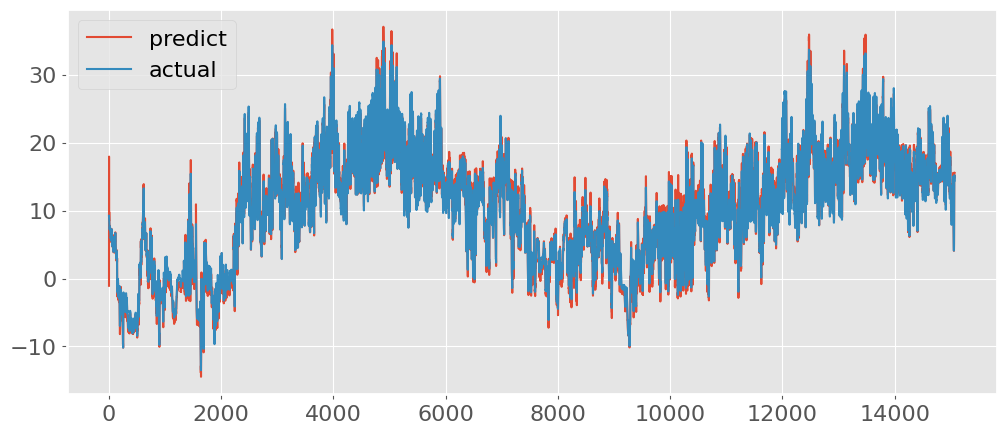

In [61]:
plt.plot(imf_eemd_fc + res1.x[0], label = 'predict')
plt.plot(test.values, label = 'actual')
plt.legend()
# plt.savefig('ImprovedEEMDSVR')
plt.show()

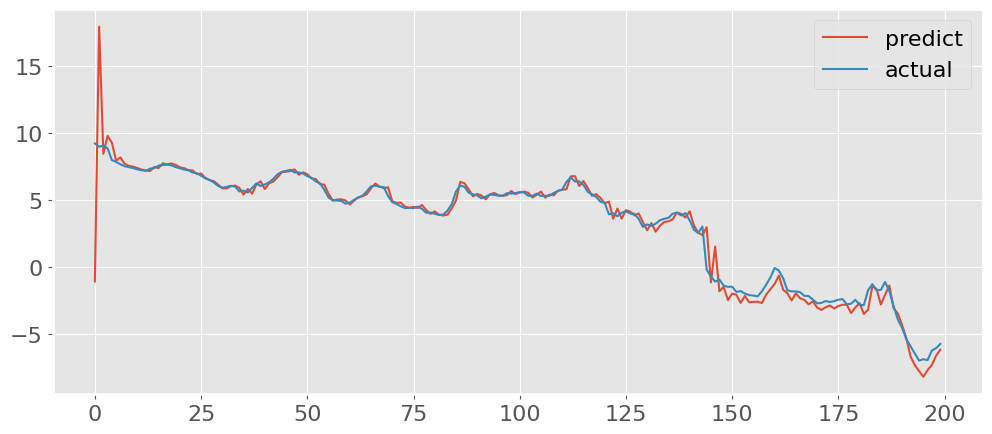

In [62]:
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'predict')
plt.plot(test.values[:200], label = 'actual')
plt.legend()
# plt.savefig('ImprovedEEMDSVR_200')
plt.show()

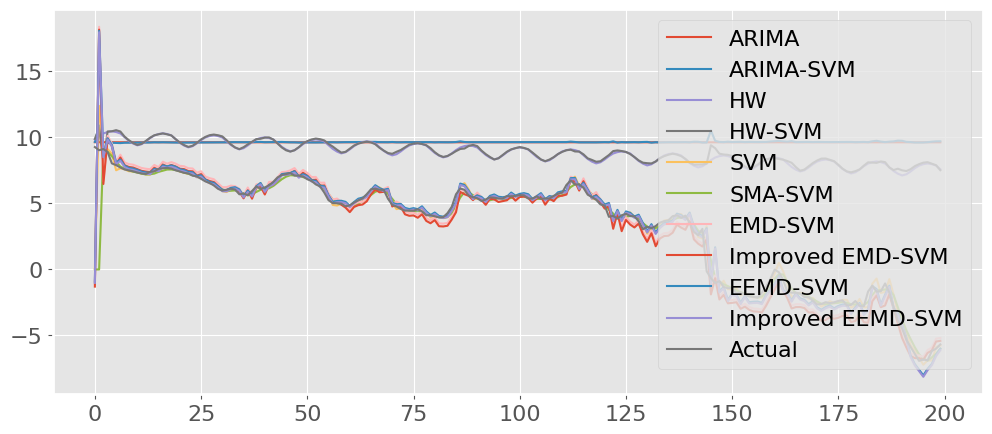

In [63]:
plt.plot(arima_fc.values[:200], label = 'ARIMA')
plt.plot(arima_SVR_fc[:200]+arima_fc.values[:200], label = 'ARIMA-SVM')
plt.plot(hw_fc.values[:200], label = 'HW')
plt.plot(hw_SVR_fc[:200]+hw_fc.values[:200], label = 'HW-SVM')
plt.plot(SVR_fc[:200], label = 'SVM')
plt.plot(SVR_MA_3_fc[0:200], label = 'SMA-SVM')
plt.plot(imf_fc[:200], label = 'EMD-SVM')
plt.plot(imf_fc[:200] + res.x[0], label = 'Improved EMD-SVM')
plt.plot(imf_eemd_fc[:200], label = 'EEMD-SVM')
plt.plot(imf_eemd_fc[:200] + res1.x[0], label = 'Improved EEMD-SVM')
plt.plot(test.values[:200], label = 'Actual')
plt.legend()
# plt.savefig('Summary')
plt.show()

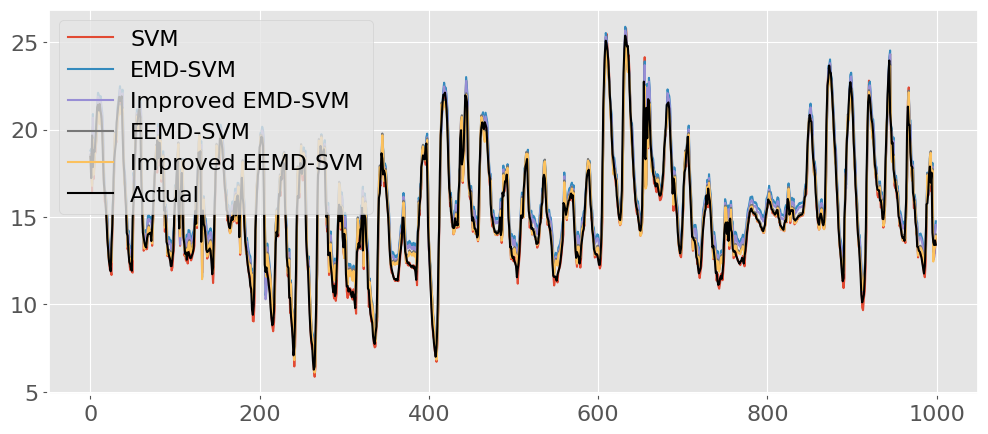

In [78]:
start = 14000
end = 15000

plt.plot(SVR_fc[start:end], label = 'SVM')
plt.plot(imf_fc[start:end], label = 'EMD-SVM')
plt.plot(imf_fc[start:end] + res.x[0], label = 'Improved EMD-SVM')
plt.plot(imf_eemd_fc[start:end], label = 'EEMD-SVM')
plt.plot(imf_eemd_fc[start:end] + res1.x[0], label = 'Improved EEMD-SVM')
plt.plot(test.values[start:end], label = 'Actual', c = 'k')
plt.legend()
# plt.savefig('Summary')
plt.show()